## Random Forest importance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

## Read Data

In [2]:
data = pd.read_csv('../Kyoto_Train.csv')
data.shape

(124055, 24)

In [3]:
data.head()

,Duration,Source,Destination_bytes,Count,Same_srv_rate,Serror_rate,Srv_serror_rate,Dst_host_count,Dst_host_srv_count,Dst_host_same_port_rate,...,Service_code,Flag_code,IDS_detection_code,Malware_detection_code,Ashula_detection_code,Source_IP_Address_code,Destination_IP_Address_code,Start_Time_code,Protocol_code,Label_code
0,2.863309,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,90847.0,14024.0,25836.0,1.0,0.0
1,0.000000,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,218531.0,8968.0,45541.0,1.0,0.0
2,0.000000,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,176665.0,15997.0,59860.0,1.0,0.0
3,0.000000,0,0,0,0.0,0.0,0.67,49,100,0.02,...,6.0,6.0,0.0,0.0,0.0,52769.0,473.0,40649.0,1.0,0.0
4,0.000000,0,0,1,1.0,0.0,0.36,0,2,0.00,...,6.0,0.0,0.0,0.0,0.0,65048.0,16609.0,39283.0,1.0,0.0


### Train - Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Label_code'], axis=1),
    data['Label_code'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((99244, 23), (24811, 23))

### Select features with tree importance

In [5]:
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=10))
sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10,
                                                 random_state=10))

In [6]:
sel_.get_support()

array([False, False,  True,  True, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True,  True, False, False])

In [7]:
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

6

In [8]:
selected_feat

Index(['Destination_bytes', 'Count', 'Dst_host_count', 'Service_code',
       'Source_IP_Address_code', 'Destination_IP_Address_code'],
      dtype='object')

### Plot importances

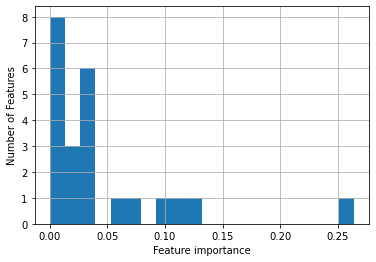

In [9]:
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

In [10]:
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print(
    'features with importance greater than the mean importance of all features: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

total features: 23
selected features: 6
features with importance greater than the mean importance of all features: 6


In [11]:
selected_feat

Index(['Destination_bytes', 'Count', 'Dst_host_count', 'Service_code',
       'Source_IP_Address_code', 'Destination_IP_Address_code'],
      dtype='object')

In [12]:
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

In [13]:
X_train.shape, X_test.shape

((99244, 6), (24811, 6))

## Standardize Data




In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers





In [15]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation



In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression




In [17]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=1).fit(X_train, y_train)

CPU times: user 69.5 ms, sys: 221 ms, total: 290 ms
Wall time: 1.48 s


In [18]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.09411148281004393
F1 Score: 0.1720327120017682
FPR: 1.0
TPR: 1.0


### Naive Bayes




In [19]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-05).fit(X_train, y_train)

CPU times: user 19.9 ms, sys: 4.55 ms, total: 24.4 ms
Wall time: 22.8 ms


In [20]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.0
FPR: 1.0
TPR: 1.0


### Random Forest






In [21]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100).fit(X_train, y_train)

CPU times: user 3.3 s, sys: 50.8 ms, total: 3.35 s
Wall time: 3.35 s


In [22]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
FPR: 1.0
TPR: 1.0


### KNN




In [23]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='auto',leaf_size=1,n_neighbors=2,weights='uniform').fit(X_train, y_train)

CPU times: user 5.74 s, sys: 35.6 ms, total: 5.77 s
Wall time: 5.75 s


In [24]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.9058885171899561
f1: 0.0
fpr: 1.0
tpr: 1.0


### CatBoost




In [25]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.6556763	total: 65.1ms	remaining: 3.19s
1:	learn: 0.6209413	total: 72.7ms	remaining: 1.75s
2:	learn: 0.5891993	total: 79.5ms	remaining: 1.25s
3:	learn: 0.5600298	total: 86.8ms	remaining: 998ms
4:	learn: 0.5316999	total: 93.7ms	remaining: 844ms
5:	learn: 0.5053832	total: 101ms	remaining: 742ms
6:	learn: 0.4810642	total: 109ms	remaining: 668ms
7:	learn: 0.4578597	total: 116ms	remaining: 607ms
8:	learn: 0.4361361	total: 122ms	remaining: 555ms
9:	learn: 0.4161064	total: 128ms	remaining: 514ms
10:	learn: 0.3979059	total: 135ms	remaining: 479ms
11:	learn: 0.3800247	total: 142ms	remaining: 450ms
12:	learn: 0.3630387	total: 149ms	remaining: 424ms
13:	learn: 0.3466373	total: 156ms	remaining: 402ms
14:	learn: 0.3315467	total: 163ms	remaining: 380ms
15:	learn: 0.3175328	total: 170ms	remaining: 362ms
16:	learn: 0.3040164	total: 177ms	remaining: 343ms
17:	learn: 0.2910111	total: 184ms	remaining: 326ms
18:	learn: 0.2782776	total: 190ms	remaining: 310ms
19:	learn: 0.2660368	total: 197ms	re

In [26]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
FPR: 1.0
TPR: 1.0


## Model Evaluation





In [27]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../Kyoto_Test.csv")
test_df.shape

(62028, 24)

In [28]:
# Create feature matrix X and target vextor y
y_eval = test_df['Label_code']
X_eval = test_df.drop(columns=['Label_code'])

In [29]:
X_eval = X_eval[selected_feat]

In [30]:
X_eval.shape

(62028, 6)

### Model Evaluation - Logistic Regression




In [32]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=1)
modelLR.fit(X_train, y_train)

LogisticRegression(C=1, n_jobs=-1, random_state=42)

In [33]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [34]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  0.9054955463302568
Testing accuracy is  0.09411148281004393


In [35]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.09411148281004393
F1 Score: 0.1720327120017682
Precision Score: 0.09411148281004393
Recall Score: 1.0
Confusion Matrix:
 [[    0 22476]
 [    0  2335]]


### Cross validation - Logistic Regression




In [36]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.90332 (+/- 0.00163)
F1 Score: 0.01554 (+/- 0.05098)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision 

Precision: 0.38672 (+/- 0.75929)
Recall: 0.00836 (+/- 0.02806)


### Model Evaluation - Naive Bayes





In [37]:
modelNB = GaussianNB(var_smoothing=1e-05)
modelNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-05)

In [38]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [39]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  0.48651807665954616
Testing accuracy is  0.9058885171899561


In [40]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross validation - Naive Bayes





In [41]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.86289 (+/- 0.23048)
F1 Score: 0.02518 (+/- 0.15109)
Precision: 0.01480 (+/- 0.08881)
Recall: 0.08428 (+/- 0.50569)


### Model Evaluation - Random Forest




In [42]:
modelRF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, random_state=0)

In [43]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [44]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  1.0
Testing accuracy is  0.9058885171899561


In [45]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
Precision Score: 0.8206340055766175
Recall Score: 0.9058885171899561
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


### Cross validation - Random Forest





In [46]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99989 (+/- 0.00025)
F1 Score: 0.99942 (+/- 0.00130)
Precision: 0.99917 (+/- 0.00269)
Recall: 0.99967 (+/- 0.00134)


### Model Evaluation - KNN



In [47]:
modelKNN = KNeighborsClassifier(algorithm='auto',leaf_size=1,n_neighbors=2,weights='uniform')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=2)

In [48]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [49]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9980351457015033
Testing accuracy is  0.9058885171899561


In [50]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross validation - KNN






In [51]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99466 (+/- 0.00192)
F1 Score: 0.97183 (+/- 0.01036)
Precision: 0.98961 (+/- 0.00348)
Recall: 0.95472 (+/- 0.01876)


### Model Evaluation - CatBoost





In [52]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.6556763	total: 6.74ms	remaining: 330ms
1:	learn: 0.6209413	total: 13.8ms	remaining: 331ms
2:	learn: 0.5891993	total: 21.1ms	remaining: 330ms
3:	learn: 0.5600298	total: 28.3ms	remaining: 326ms
4:	learn: 0.5316999	total: 35.1ms	remaining: 316ms
5:	learn: 0.5053832	total: 41.6ms	remaining: 305ms
6:	learn: 0.4810642	total: 48.5ms	remaining: 298ms
7:	learn: 0.4578597	total: 55.2ms	remaining: 290ms
8:	learn: 0.4361361	total: 61.5ms	remaining: 280ms
9:	learn: 0.4161064	total: 67.6ms	remaining: 270ms
10:	learn: 0.3979059	total: 73.7ms	remaining: 261ms
11:	learn: 0.3800247	total: 80.2ms	remaining: 254ms
12:	learn: 0.3630387	total: 86.7ms	remaining: 247ms
13:	learn: 0.3466373	total: 93.1ms	remaining: 239ms
14:	learn: 0.3315467	total: 99.5ms	remaining: 232ms
15:	learn: 0.3175328	total: 106ms	remaining: 225ms
16:	learn: 0.3040164	total: 112ms	remaining: 218ms
17:	learn: 0.2910111	total: 119ms	remaining: 212ms
18:	learn: 0.2782776	total: 126ms	remaining: 205ms
19:	learn: 0.2660368	total

In [53]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [54]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  0.9963423481520294
Testing accuracy is  0.9058885171899561


In [55]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
Precision Score: 0.8206340055766175
Recall Score: 0.9058885171899561
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


### Cross validation - CatBoost





In [56]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6557478	total: 5.26ms	remaining: 258ms
1:	learn: 0.6208123	total: 10.8ms	remaining: 258ms
2:	learn: 0.5901279	total: 16.9ms	remaining: 265ms
3:	learn: 0.5595384	total: 22.2ms	remaining: 255ms
4:	learn: 0.5318518	total: 27.4ms	remaining: 247ms
5:	learn: 0.5059281	total: 32.7ms	remaining: 240ms
6:	learn: 0.4814369	total: 37.7ms	remaining: 232ms
7:	learn: 0.4581175	total: 43.7ms	remaining: 229ms
8:	learn: 0.4364403	total: 49ms	remaining: 223ms
9:	learn: 0.4163883	total: 54ms	remaining: 216ms
10:	learn: 0.3982334	total: 58.9ms	remaining: 209ms
11:	learn: 0.3804759	total: 63.9ms	remaining: 202ms
12:	learn: 0.3635456	total: 69ms	remaining: 196ms
13:	learn: 0.3468689	total: 74ms	remaining: 190ms
14:	learn: 0.3318577	total: 79.1ms	remaining: 185ms
15:	learn: 0.3177880	total: 84.2ms	remaining: 179ms
16:	learn: 0.3039427	total: 89.2ms	remaining: 173ms
17:	learn: 0.2909803	total: 94.3ms	remaining: 168ms
18:	learn: 0.2778954	total: 99.9ms	remaining: 163ms
19:	learn: 0.2666655	total: 10

25:	learn: 0.2053041	total: 133ms	remaining: 123ms
26:	learn: 0.1967012	total: 138ms	remaining: 118ms
27:	learn: 0.1882156	total: 143ms	remaining: 112ms
28:	learn: 0.1801385	total: 148ms	remaining: 107ms
29:	learn: 0.1731662	total: 153ms	remaining: 102ms
30:	learn: 0.1662874	total: 158ms	remaining: 96.8ms
31:	learn: 0.1598332	total: 163ms	remaining: 91.8ms
32:	learn: 0.1531454	total: 169ms	remaining: 87ms
33:	learn: 0.1473630	total: 174ms	remaining: 81.9ms
34:	learn: 0.1411630	total: 179ms	remaining: 76.8ms
35:	learn: 0.1353919	total: 184ms	remaining: 71.7ms
36:	learn: 0.1302535	total: 190ms	remaining: 66.8ms
37:	learn: 0.1254231	total: 195ms	remaining: 61.7ms
38:	learn: 0.1207426	total: 200ms	remaining: 56.5ms
39:	learn: 0.1163892	total: 205ms	remaining: 51.3ms
40:	learn: 0.1122779	total: 210ms	remaining: 46.2ms
41:	learn: 0.1076830	total: 215ms	remaining: 41ms
42:	learn: 0.1036996	total: 220ms	remaining: 35.9ms
43:	learn: 0.1000394	total: 226ms	remaining: 30.8ms
44:	learn: 0.0962318	

46:	learn: 0.0910942	total: 237ms	remaining: 15.1ms
47:	learn: 0.0879724	total: 241ms	remaining: 10.1ms
48:	learn: 0.0844808	total: 246ms	remaining: 5.03ms
49:	learn: 0.0812042	total: 251ms	remaining: 0us
0:	learn: 0.6557486	total: 5.37ms	remaining: 263ms
1:	learn: 0.6205852	total: 10.4ms	remaining: 250ms
2:	learn: 0.5899863	total: 15.4ms	remaining: 241ms
3:	learn: 0.5594378	total: 20.3ms	remaining: 234ms
4:	learn: 0.5312622	total: 26.1ms	remaining: 235ms
5:	learn: 0.5054020	total: 31.1ms	remaining: 228ms
6:	learn: 0.4809624	total: 36.2ms	remaining: 222ms
7:	learn: 0.4575593	total: 41.2ms	remaining: 217ms
8:	learn: 0.4359408	total: 46.2ms	remaining: 210ms
9:	learn: 0.4159131	total: 51.7ms	remaining: 207ms
10:	learn: 0.3976158	total: 56.5ms	remaining: 200ms
11:	learn: 0.3799918	total: 61.4ms	remaining: 194ms
12:	learn: 0.3627737	total: 67ms	remaining: 191ms
13:	learn: 0.3463715	total: 72.4ms	remaining: 186ms
14:	learn: 0.3313237	total: 77.4ms	remaining: 181ms
15:	learn: 0.3173055	total:

14:	learn: 0.3318577	total: 76.3ms	remaining: 178ms
15:	learn: 0.3177880	total: 81.2ms	remaining: 173ms
16:	learn: 0.3039427	total: 86.1ms	remaining: 167ms
17:	learn: 0.2909803	total: 91.9ms	remaining: 163ms
18:	learn: 0.2778954	total: 96.9ms	remaining: 158ms
19:	learn: 0.2666655	total: 102ms	remaining: 153ms
20:	learn: 0.2555214	total: 107ms	remaining: 148ms
21:	learn: 0.2446615	total: 112ms	remaining: 143ms
22:	learn: 0.2351754	total: 117ms	remaining: 138ms
23:	learn: 0.2248989	total: 123ms	remaining: 133ms
24:	learn: 0.2156179	total: 128ms	remaining: 128ms
25:	learn: 0.2071339	total: 132ms	remaining: 122ms
26:	learn: 0.1982798	total: 137ms	remaining: 117ms
27:	learn: 0.1904044	total: 142ms	remaining: 112ms
28:	learn: 0.1830905	total: 147ms	remaining: 107ms
29:	learn: 0.1760265	total: 153ms	remaining: 102ms
30:	learn: 0.1689591	total: 158ms	remaining: 97ms
31:	learn: 0.1624672	total: 163ms	remaining: 91.9ms
32:	learn: 0.1557371	total: 169ms	remaining: 87.2ms
33:	learn: 0.1497385	tota

25:	learn: 0.2053041	total: 130ms	remaining: 120ms
26:	learn: 0.1967012	total: 135ms	remaining: 115ms
27:	learn: 0.1882156	total: 140ms	remaining: 110ms
28:	learn: 0.1801385	total: 145ms	remaining: 105ms
29:	learn: 0.1731662	total: 150ms	remaining: 100ms
30:	learn: 0.1662874	total: 155ms	remaining: 95ms
31:	learn: 0.1598332	total: 160ms	remaining: 89.9ms
32:	learn: 0.1531454	total: 165ms	remaining: 85ms
33:	learn: 0.1473630	total: 170ms	remaining: 80ms
34:	learn: 0.1411630	total: 175ms	remaining: 75.1ms
35:	learn: 0.1353919	total: 180ms	remaining: 70.2ms
36:	learn: 0.1302535	total: 185ms	remaining: 65.1ms
37:	learn: 0.1254231	total: 191ms	remaining: 60.2ms
38:	learn: 0.1207426	total: 195ms	remaining: 55.1ms
39:	learn: 0.1163892	total: 200ms	remaining: 50.1ms
40:	learn: 0.1122779	total: 205ms	remaining: 45.1ms
41:	learn: 0.1076830	total: 210ms	remaining: 40ms
42:	learn: 0.1036996	total: 215ms	remaining: 35ms
43:	learn: 0.1000394	total: 220ms	remaining: 30ms
44:	learn: 0.0962318	total: 2

48:	learn: 0.0844808	total: 248ms	remaining: 5.05ms
49:	learn: 0.0812042	total: 253ms	remaining: 0us
0:	learn: 0.6557486	total: 5.72ms	remaining: 280ms
1:	learn: 0.6205852	total: 10.8ms	remaining: 258ms
2:	learn: 0.5899863	total: 15.9ms	remaining: 249ms
3:	learn: 0.5594378	total: 21.1ms	remaining: 242ms
4:	learn: 0.5312622	total: 26.3ms	remaining: 237ms
5:	learn: 0.5054020	total: 31.5ms	remaining: 231ms
6:	learn: 0.4809624	total: 36.4ms	remaining: 224ms
7:	learn: 0.4575593	total: 41.6ms	remaining: 219ms
8:	learn: 0.4359408	total: 46.5ms	remaining: 212ms
9:	learn: 0.4159131	total: 51.7ms	remaining: 207ms
10:	learn: 0.3976158	total: 56.8ms	remaining: 201ms
11:	learn: 0.3799918	total: 61.7ms	remaining: 195ms
12:	learn: 0.3627737	total: 66.8ms	remaining: 190ms
13:	learn: 0.3463715	total: 72.2ms	remaining: 186ms
14:	learn: 0.3313237	total: 77.2ms	remaining: 180ms
15:	learn: 0.3173055	total: 82ms	remaining: 174ms
16:	learn: 0.3038611	total: 87.1ms	remaining: 169ms
17:	learn: 0.2912040	total:

18:	learn: 0.2778954	total: 97.3ms	remaining: 159ms
19:	learn: 0.2666655	total: 102ms	remaining: 154ms
20:	learn: 0.2555214	total: 108ms	remaining: 149ms
21:	learn: 0.2446615	total: 113ms	remaining: 144ms
22:	learn: 0.2351754	total: 118ms	remaining: 139ms
23:	learn: 0.2248989	total: 123ms	remaining: 134ms
24:	learn: 0.2156179	total: 129ms	remaining: 129ms
25:	learn: 0.2071339	total: 134ms	remaining: 124ms
26:	learn: 0.1982798	total: 140ms	remaining: 119ms
27:	learn: 0.1904044	total: 145ms	remaining: 114ms
28:	learn: 0.1830905	total: 150ms	remaining: 109ms
29:	learn: 0.1760265	total: 155ms	remaining: 103ms
30:	learn: 0.1689591	total: 161ms	remaining: 98.4ms
31:	learn: 0.1624672	total: 166ms	remaining: 93.3ms
32:	learn: 0.1557371	total: 171ms	remaining: 88ms
33:	learn: 0.1497385	total: 176ms	remaining: 82.9ms
34:	learn: 0.1442776	total: 182ms	remaining: 77.8ms
35:	learn: 0.1384013	total: 187ms	remaining: 72.6ms
36:	learn: 0.1328350	total: 192ms	remaining: 67.4ms
37:	learn: 0.1279425	tota

38:	learn: 0.1207426	total: 205ms	remaining: 57.7ms
39:	learn: 0.1163892	total: 210ms	remaining: 52.5ms
40:	learn: 0.1122779	total: 215ms	remaining: 47.2ms
41:	learn: 0.1076830	total: 220ms	remaining: 41.9ms
42:	learn: 0.1036996	total: 225ms	remaining: 36.6ms
43:	learn: 0.1000394	total: 230ms	remaining: 31.3ms
44:	learn: 0.0962318	total: 235ms	remaining: 26.1ms
45:	learn: 0.0923702	total: 240ms	remaining: 20.9ms
46:	learn: 0.0891090	total: 246ms	remaining: 15.7ms
47:	learn: 0.0859633	total: 251ms	remaining: 10.5ms
48:	learn: 0.0825393	total: 256ms	remaining: 5.22ms
49:	learn: 0.0793796	total: 261ms	remaining: 0us
0:	learn: 0.6557568	total: 4.94ms	remaining: 242ms
1:	learn: 0.6209923	total: 9.87ms	remaining: 237ms
2:	learn: 0.5900638	total: 15.1ms	remaining: 237ms
3:	learn: 0.5593912	total: 20.1ms	remaining: 231ms
4:	learn: 0.5314529	total: 24.9ms	remaining: 224ms
5:	learn: 0.5059081	total: 29.7ms	remaining: 218ms
6:	learn: 0.4814824	total: 34.5ms	remaining: 212ms
7:	learn: 0.4582592	to

5:	learn: 0.5054020	total: 30.7ms	remaining: 225ms
6:	learn: 0.4809624	total: 35.8ms	remaining: 220ms
7:	learn: 0.4575593	total: 40.8ms	remaining: 214ms
8:	learn: 0.4359408	total: 45.8ms	remaining: 208ms
9:	learn: 0.4159131	total: 50.8ms	remaining: 203ms
10:	learn: 0.3976158	total: 55.7ms	remaining: 198ms
11:	learn: 0.3799918	total: 61.1ms	remaining: 194ms
12:	learn: 0.3627737	total: 66.1ms	remaining: 188ms
13:	learn: 0.3463715	total: 71.4ms	remaining: 184ms
14:	learn: 0.3313237	total: 76.6ms	remaining: 179ms
15:	learn: 0.3173055	total: 81.8ms	remaining: 174ms
16:	learn: 0.3038611	total: 86.8ms	remaining: 169ms
17:	learn: 0.2912040	total: 92ms	remaining: 164ms
18:	learn: 0.2788952	total: 97ms	remaining: 158ms
19:	learn: 0.2674110	total: 102ms	remaining: 152ms
20:	learn: 0.2563615	total: 107ms	remaining: 148ms
21:	learn: 0.2456618	total: 112ms	remaining: 143ms
22:	learn: 0.2356055	total: 117ms	remaining: 138ms
23:	learn: 0.2253118	total: 123ms	remaining: 133ms
24:	learn: 0.2164201	total

38:	learn: 0.1231688	total: 200ms	remaining: 56.5ms
39:	learn: 0.1190356	total: 206ms	remaining: 51.6ms
40:	learn: 0.1147585	total: 211ms	remaining: 46.4ms
41:	learn: 0.1100582	total: 216ms	remaining: 41.2ms
42:	learn: 0.1063319	total: 221ms	remaining: 36ms
43:	learn: 0.1026384	total: 226ms	remaining: 30.8ms
44:	learn: 0.0987785	total: 231ms	remaining: 25.6ms
45:	learn: 0.0952889	total: 236ms	remaining: 20.6ms
46:	learn: 0.0919864	total: 242ms	remaining: 15.4ms
47:	learn: 0.0888204	total: 247ms	remaining: 10.3ms
48:	learn: 0.0852417	total: 252ms	remaining: 5.14ms
49:	learn: 0.0820441	total: 257ms	remaining: 0us
0:	learn: 0.6557656	total: 5.09ms	remaining: 250ms
1:	learn: 0.6209720	total: 10.3ms	remaining: 246ms
2:	learn: 0.5893503	total: 15.5ms	remaining: 243ms
3:	learn: 0.5587330	total: 20.5ms	remaining: 236ms
4:	learn: 0.5306194	total: 25.5ms	remaining: 229ms
5:	learn: 0.5047979	total: 30.4ms	remaining: 223ms
6:	learn: 0.4806206	total: 35.2ms	remaining: 216ms
7:	learn: 0.4574642	tota

5:	learn: 0.5059081	total: 31.2ms	remaining: 229ms
6:	learn: 0.4814824	total: 36.7ms	remaining: 226ms
7:	learn: 0.4582592	total: 41.7ms	remaining: 219ms
8:	learn: 0.4365301	total: 46.8ms	remaining: 213ms
9:	learn: 0.4164867	total: 51.6ms	remaining: 207ms
10:	learn: 0.3983099	total: 56.7ms	remaining: 201ms
11:	learn: 0.3805277	total: 61.7ms	remaining: 195ms
12:	learn: 0.3636327	total: 66.6ms	remaining: 190ms
13:	learn: 0.3472483	total: 72.2ms	remaining: 186ms
14:	learn: 0.3321623	total: 77.8ms	remaining: 181ms
15:	learn: 0.3181455	total: 83.1ms	remaining: 177ms
16:	learn: 0.3045210	total: 88.2ms	remaining: 171ms
17:	learn: 0.2913307	total: 93ms	remaining: 165ms
18:	learn: 0.2785838	total: 98.3ms	remaining: 160ms
19:	learn: 0.2670969	total: 103ms	remaining: 155ms
20:	learn: 0.2559158	total: 109ms	remaining: 150ms
21:	learn: 0.2448820	total: 114ms	remaining: 145ms
22:	learn: 0.2348012	total: 119ms	remaining: 140ms
23:	learn: 0.2251262	total: 125ms	remaining: 135ms
24:	learn: 0.2160320	tot

28:	learn: 0.1837053	total: 148ms	remaining: 107ms
29:	learn: 0.1766481	total: 153ms	remaining: 102ms
30:	learn: 0.1696174	total: 158ms	remaining: 96.8ms
31:	learn: 0.1632512	total: 163ms	remaining: 91.5ms
32:	learn: 0.1569230	total: 168ms	remaining: 86.3ms
33:	learn: 0.1510502	total: 173ms	remaining: 81.2ms
34:	learn: 0.1447452	total: 178ms	remaining: 76.2ms
35:	learn: 0.1386873	total: 183ms	remaining: 71.3ms
36:	learn: 0.1334813	total: 189ms	remaining: 66.2ms
37:	learn: 0.1286202	total: 194ms	remaining: 61.2ms
38:	learn: 0.1235601	total: 199ms	remaining: 56.1ms
39:	learn: 0.1192521	total: 204ms	remaining: 51ms
40:	learn: 0.1150400	total: 209ms	remaining: 45.9ms
41:	learn: 0.1103727	total: 215ms	remaining: 40.9ms
42:	learn: 0.1065844	total: 220ms	remaining: 35.7ms
43:	learn: 0.1029002	total: 225ms	remaining: 30.6ms
44:	learn: 0.0991576	total: 230ms	remaining: 25.5ms
45:	learn: 0.0953106	total: 235ms	remaining: 20.4ms
46:	learn: 0.0913579	total: 240ms	remaining: 15.3ms
47:	learn: 0.088

In [57]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99628 (+/- 0.00225)
F1 Score: 0.98030 (+/- 0.01218)
Precision: 0.99914 (+/- 0.00231)
Recall: 0.96223 (+/- 0.02396)
